# REopt API Benchmarking of CHP+ Additions

## Initialization

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Read in benchmarking data to Pandas DataFrams

In [4]:
bench_5 = pd.read_csv("results_FivePercentGap.csv", index_col="file")
bench_8 = pd.read_csv("results_EightPercentGap.csv", index_col="file")
bench_const = pd.read_csv("results_FivePctGapConst.csv", index_col="file")
bench_max = pd.read_csv("results_FivePctGap400maxkw.csv", index_col="file")
bench_gap = pd.read_csv("results_FivePctGapBothTESReportGap.csv", index_col="file")
bench_const4 = pd.read_csv("results_FivePctFourItersConstFull.csv", index_col="file")
# Fixed ColdTES evaluation because above runs did not have a cooling load
bench_const3pctfixcool = pd.read_csv("results_ThreePctConstFullOneIterFixedCool.csv", index_col="file")
bench_monoconst3pct = pd.read_csv("results_ThreePctMonolithConstFullOneIter.csv", index_col="file")
bench_monoconstHalfpct = pd.read_csv("results_HalfPctMonolithConstFullOneIter.csv", index_col="file")
bench_minsizes3Pct1PctSub = pd.read_csv("results_ThreePctMinSizes1PctSubGapConst.csv", index_col="file")
bench_const1pct900secs = pd.read_csv("results_OnePct900SecsConst.csv", index_col="file")
bench_mono1pct900secsconst = pd.read_csv("results_MonoOnePct900SecsConst.csv", index_col="file")
bench_mono5pct900secs = pd.read_csv("results_MonoFivePct900Secs.csv", index_col="file")
bench_minsizes3pctconst = pd.read_csv("results_DecompMinSizesThreePct900SecsConst.csv", index_col="file")
bench_monocostcurve1pctconst = pd.read_csv("results_MonoOnePctCostCurve900SecsConst.csv", index_col="file")
bench_decompcostcurve3pctconst = pd.read_csv("results_DecompThreePctCostCurve900SecsConst.csv", index_col="file")
bench_private5pctconstc110p = pd.read_csv("results_PrivateFivePct420SecsC110PConst.csv", index_col="file")
bench_minsizesupdated3pctconst = pd.read_csv("results_DecompUpdated2MinSizesThreePct900SecsConst.csv", index_col="file")

<IPython.core.display.Javascript object>


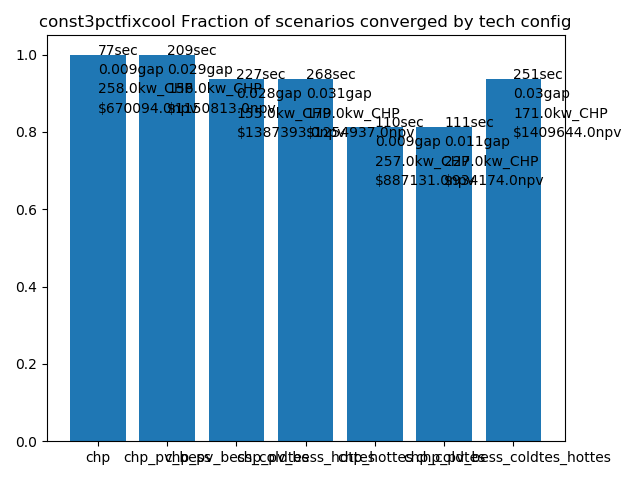

In [4]:
scenario = "const3pctfixcool"
for s in [scenario]:
    bench = copy.deepcopy(eval("bench_"+s))
    tech_configs = ['chp', 'chp_pv_bess', 'chp_pv_bess_coldtes', 'chp_pv_bess_hottes', 
                'chp_hottes', 'chp_coldtes', 'chp_pv_bess_coldtes_hottes']
    if 'pv_bess' in list(bench["tech_choice"]):
        tech_configs = ['pv_bess'] + tech_configs
    by_tech = {t: bench[bench["tech_choice"] == t] for t in tech_configs}
    num_cases = len(bench)
    avg_time = {t: np.sum(by_tech[t]['reopt_seconds'].dropna()) / len(by_tech[t]['lcc'].dropna()) for t in tech_configs}
    if 'gap' in list(bench.columns):
        avg_gap = {t: np.sum(by_tech[t]['gap'].dropna()) / len(by_tech[t]['lcc'].dropna()) for t in tech_configs}
    else:
        avg_gap = {t: 0.0 for t in tech_configs}
    avg_chp_kw = {t: np.sum(by_tech[t]['chp_kw'].dropna()) / len(by_tech[t]['lcc'].dropna()) for t in tech_configs}
    avg_npv = {t: np.sum(by_tech[t]['npv'].dropna()) / len(by_tech[t]['lcc'].dropna()) for t in tech_configs}
    plt.bar(by_tech.keys(), [len(by_tech[t]['lcc'].dropna())/len(by_tech[t]['lcc']) for t in by_tech.keys()])
    # Show average time for the ones that solved
    for t in tech_configs:
        plt.text(t, len(by_tech[t]['lcc'].dropna())/len(by_tech[t]['lcc']), str(int(avg_time[t])) + "sec", fontdict=None)
        plt.text(t, len(by_tech[t]['lcc'].dropna())/len(by_tech[t]['lcc'])-0.05, str(round(avg_gap[t],3)) + "gap", fontdict=None)
        plt.text(t, len(by_tech[t]['lcc'].dropna())/len(by_tech[t]['lcc'])-0.1, str(round(avg_chp_kw[t],0)) + "kw_CHP", fontdict=None)
        plt.text(t, len(by_tech[t]['lcc'].dropna())/len(by_tech[t]['lcc'])-0.15, "$" + str(round(avg_npv[t],0)) + "npv", fontdict=None)
    plt.title(scenario + " Fraction of scenarios converged by tech config")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


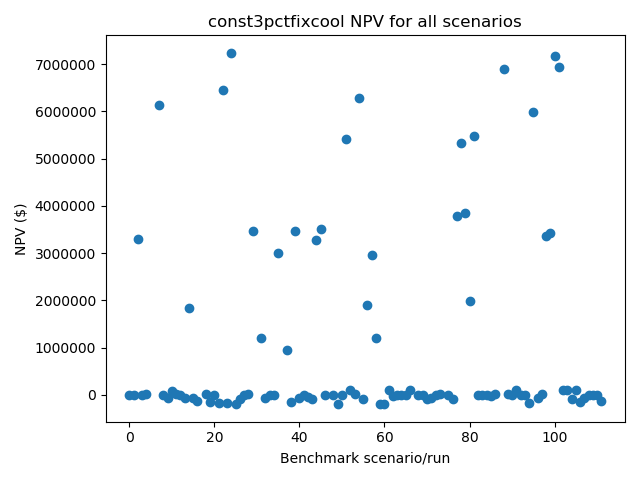

Number of negative NPV solutions =  32


In [5]:
neg_npv = bench[bench["npv"] < -0.01]
plt.scatter(range(len(bench["npv"].index)), bench["npv"])
plt.title(scenario + " NPV for all scenarios")
plt.ylabel("NPV ($)")
plt.xlabel("Benchmark scenario/run")
plt.tight_layout()
plt.show()
#print("Calc'd gap for negative NPV chp_pv_bess = ", neg_npv[neg_npv["tech_choice"]=="chp_pv_bess"]["npv"]/neg_npv[neg_npv["tech_choice"]=="chp_pv_bess"]["lcc"])
#print("Model gap output from decomp [LCC_objval - LCC_lb] = ", neg_npv[neg_npv["tech_choice"]=="chp_pv_bess"]["gap"])
print("Number of negative NPV solutions = ", len(neg_npv))

# Compare results across API versions and settings

In [6]:
# Load in all API results into a dictionary of dataframes
bench_names = ['monoconst3pct', 'mono1pct900secsconst', 'monoconstHalfpct', 'monocostcurve1pctconst',  # Constant CHP efficiencies
               'mono5pct900secs',  # Variable CHP efficiencies
               'const3pctfixcool', 'const1pct900secs', 'decompcostcurve3pctconst',  # Decomposition, const effic
               'private5pctconstc110p'] # Private, const effic
bench_all = {api: copy.deepcopy(eval("bench_"+api)) for api in bench_names}

In [7]:
# Pick the metrics to extract from each API for all scenarios
# Format --> e.g. {"npv": df of NPV for all APIs for all scenarios, "chp_kw": def of chp_kw for all API's for all scenarios}
# TODO check if this is doing some unintended filtering of the data (e.g. no pv_bess)
metric_list = ["npv", "chp_kw"]
agg_data = {metric: pd.DataFrame(index=bench_all['monoconst3pct'].index) for metric in metric_list}
for metric in metric_list:
    for bench_name, bench_data_df in bench_all.items():
        agg_data[metric] = agg_data[metric].join(pd.Series(bench_data_df[metric], name=bench_name))

In [8]:
# Further filter on API's to compare against (values expected to be same if life was perfect), e.g. same set of inputs but different API settings or versions
tech_config = "chp_pv_bess_coldtes_hottes"
chp_effic = "const"  # "variable"
bench_const = [name for name in bench_names if "const" in name if "curve" not in name]
bench_variable = [name for name in bench_names if "const" not in name if "curve" not in name]

In [11]:
# NPV
const_npv = copy.deepcopy(agg_data["npv"].loc[:,bench_const])
const_npv = const_npv.filter(regex=tech_config+"_San", axis='index')
const_npv_positive = const_npv[const_npv > 0]#.dropna(how='all')

# CHP size
const_chp_kw = copy.deepcopy(agg_data["chp_kw"].loc[:,bench_const])
const_chp_kw = const_chp_kw.filter(regex=tech_config+"_San", axis='index')
#const_chp_kw = const_chp_kw[const_chp_kw > 50000].dropna(how='all')

In [12]:
# Look closer at data in tabular
selected = agg_data["npv"][agg_data["npv"] < 0]["monoconst3pct"].dropna()

<IPython.core.display.Javascript object>


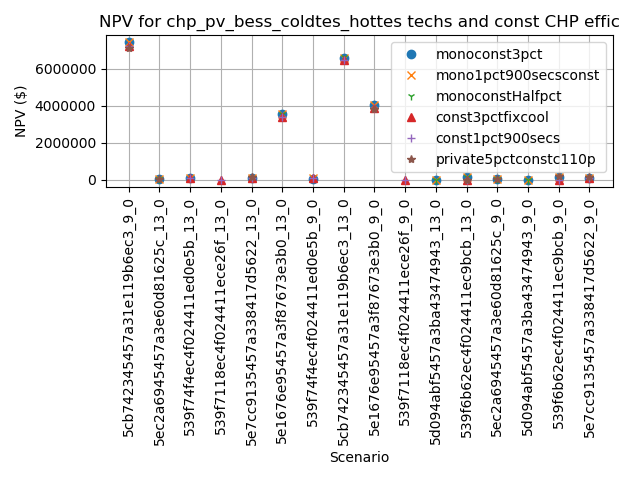

In [13]:
# Remove redundant text in scenario name to clean up the labels to compare differences
rm_list = [tech_config + "_SanFrancisco_Hospital_", ".json"]
for rm in rm_list:
    const_npv_positive.index = [name.replace(rm,"") for name in const_npv_positive.index.values]

markers = ["o","x","1","^","+","*"]    
for i, col in enumerate(const_npv_positive.columns):
    plt.plot(const_npv_positive[col], label=col, linewidth=0, marker=markers[i])
plt.grid()
plt.legend(const_npv_positive.columns)
plt.ylabel("NPV ($)")
plt.xlabel("Scenario")
plt.xticks(rotation='vertical')
plt.title("NPV for " + tech_config + " techs and " + chp_effic + " CHP effic")
plt.tight_layout()

<IPython.core.display.Javascript object>


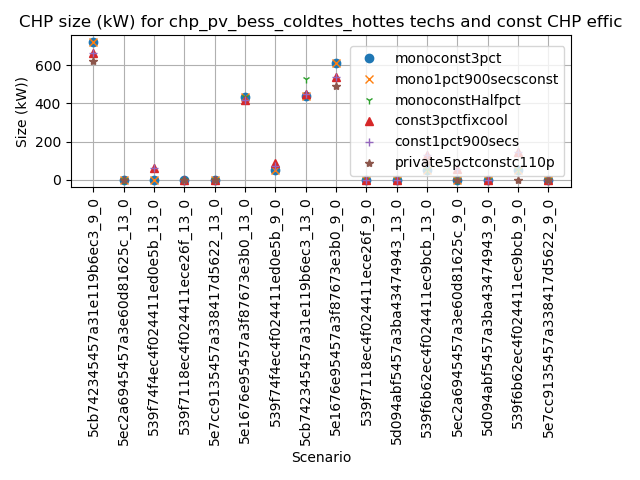

In [330]:
for rm in rm_list:
    const_chp_kw.index = [name.replace(rm,"") for name in const_chp_kw.index.values]

#fig, ax = plt.subplots()
for i, col in enumerate(const_chp_kw.columns):
    plt.plot(const_chp_kw[col], label=col, linewidth=0, marker=markers[i])
plt.grid()
plt.legend(loc="center right")
plt.ylabel("Size (kW))")
plt.xlabel("Scenario")
plt.xticks(rotation='vertical')
plt.title("CHP size (kW) for " + tech_config + " techs and " + chp_effic + " CHP effic")
plt.tight_layout()

# Compare the inputs of two models/files/dictionaries

In [ ]:
# Load in .json files for two different models
root_dir = r"C:\Bill\Projects\AMO"
compare = ["PrivateFivePct420SecsC110PConst", "MonoOnePct900SecsConst"]
case = "chp_pv_bess_coldtes_hottes_SanFrancisco_Hospital_5cb742345457a31e119b6ec3_9_0"
files = [os.path.join(root_dir, model, case) + ".json" for model in compare]
data = {}
for i, file in enumerate(files):
    try:
        data[compare[i]] = json.loads(eval(open(file).read()))
    except:
        data[compare[i]] = json.loads(open(file).read())

In [ ]:
# Must pip install deepdiff which recursively checks nested dictionary differences
import deepdiff
diff = {}
for check in ["CHP", "Financial", "HotTES","ColdTES","PV","Storage"]:
    pre = "['inputs']['Scenario']['Site']"
#     diff[check] = deepdiff.DeepDiff(eval("data[compare[0]]"+pre+"["+check+"]"), 
#                                     eval("data[compare[1]]"+pre+"["+check+"]"))
    diff[check] = deepdiff.DeepDiff(data[compare[0]]['inputs']['Scenario']['Site'][check], 
                                    data[compare[1]]['inputs']['Scenario']['Site'][check])
    print(check+ " diff = ", diff[check])